In [1]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

import matplotlib as mpl
font = {"family":"osaka"}
mpl.rc('font', **font)

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [3]:
def pos_neg(team, nlead=5, nbehind=4, year="both"):
    start_inning = 1
    end_inning = 7
    
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif year == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif year == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
        
    # 点差関係なし
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[start_inning-1:end_inning])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    all_imp, all_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    #  nlead点差以上リード
    lst = triple_on_score_diff(team, nlead, 30, year, start_inning=start_inning, end_inning=end_inning)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    pos_imp, pos_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    # nbehind点差以上ビハインド
    lst = triple_on_score_diff(team, -nbehind, -1, year, start_inning=start_inning, end_inning=end_inning)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    neg_imp, neg_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    return [team, all_imp, all_det, pos_imp, pos_det, neg_imp, neg_det]

In [4]:
#pos_neg("インディアンス", year=2017)

In [5]:
res = []
for team in teams_mlb:
    curr = pos_neg(team, year=2018)
    curr[0] = curr[0] + "2018"
    res.append(curr)
    print(curr[0])
    curr = pos_neg(team, year=2017)
    curr[0] = curr[0] + "2017"
    res.append(curr)
    print(curr[0])

インディアンス2018
インディアンス2017
カージナルス2018
カージナルス2017
レイズ2018
レイズ2017
マリナーズ2018
マリナーズ2017
フィリーズ2018
フィリーズ2017
ロッキーズ2018
ロッキーズ2017
ドジャース2018
ドジャース2017
Rソックス2018
Rソックス2017
Dバックス2018
Dバックス2017
メッツ2018
メッツ2017
ブリュワーズ2018
ブリュワーズ2017
アストロズ2018
アストロズ2017
ナショナルズ2018
ナショナルズ2017
Wソックス2018
Wソックス2017
パイレーツ2018
パイレーツ2017
マーリンズ2018
マーリンズ2017
ジャイアンツ2018
ジャイアンツ2017
ツインズ2018
ツインズ2017
レンジャーズ2018
レンジャーズ2017
パドレス2018
パドレス2017
アスレチックス2018
アスレチックス2017
エンゼルス2018
エンゼルス2017
ブレーブス2018
ブレーブス2017
ブルージェイズ2018
ブルージェイズ2017
ロイヤルズ2018
ロイヤルズ2017
オリオールズ2018
オリオールズ2017
ヤンキース2018
ヤンキース2017
レッズ2018
レッズ2017
タイガース2018
タイガース2017
カブス2018
カブス2017


In [6]:
df = pd.DataFrame(res, columns=["チーム", "all_imp", "all_det", "pos_imp", "pos_det", "neg_imp", "neg_det"]).set_index("チーム", drop=True)

In [7]:
df["positive_inhibition"] = - df["pos_imp"] + df["all_imp"]
df["negative_facilitation"] = df["neg_det"] - df["all_det"]

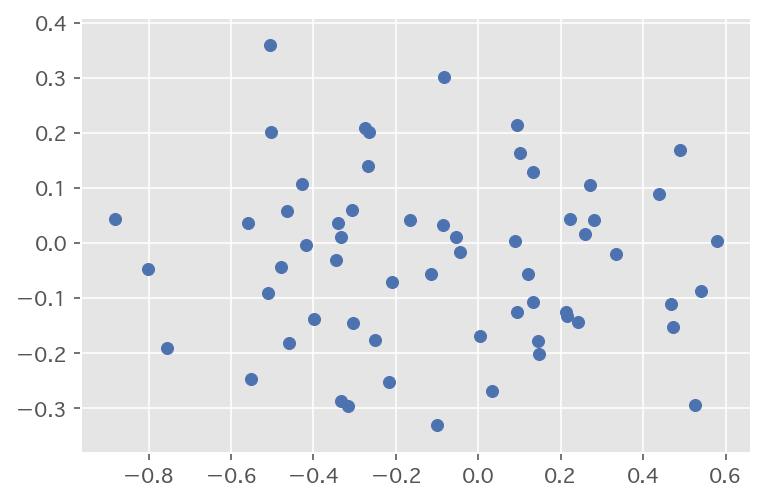

In [8]:
df[["positive_inhibition", "negative_facilitation"]]
plt.scatter(df["positive_inhibition"], df["negative_facilitation"])

In [9]:
df

,all_imp,all_det,pos_imp,pos_det,neg_imp,neg_det,positive_inhibition,negative_facilitation
チーム,,,,,,,,
インディアンス2018,1.083449,1.020289,1.388885,0.854375,1.332125,1.079597,-0.305436,0.059309
インディアンス2017,0.928023,1.061397,0.808198,0.889099,0.668244,1.005432,0.119826,-0.055965
カージナルス2018,0.972098,0.822398,1.180509,0.499940,0.838090,0.752368,-0.208410,-0.070030
カージナルス2017,0.905881,0.939741,1.172073,0.779434,1.108293,1.141563,-0.266192,0.201823
レイズ2018,0.740615,0.747933,0.652043,1.490823,0.404917,0.752115,0.088573,0.004182
レイズ2017,0.932194,1.068173,1.812880,1.458750,0.806446,1.112065,-0.880685,0.043892
マリナーズ2018,0.943077,0.905922,0.988645,0.637746,1.057853,0.889682,-0.045568,-0.016240
マリナーズ2017,0.959134,0.957374,1.059021,1.632637,1.062780,0.626974,-0.099887,-0.330400
フィリーズ2018,0.883255,0.801691,1.385447,0.751463,0.724058,1.002618,-0.502192,0.200927


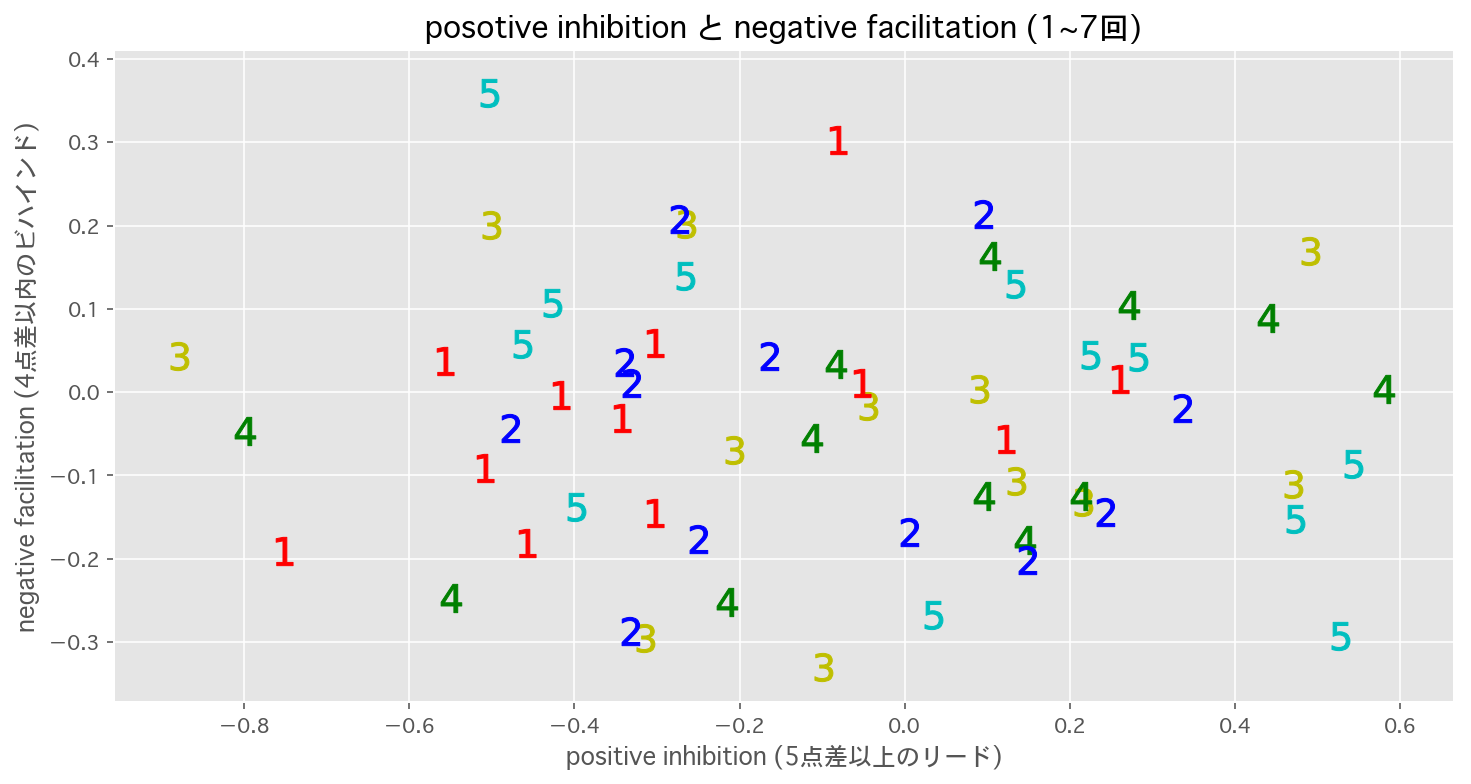

In [26]:
plt.figure(figsize=(12, 6))
colors = ["r", "b", "y", "g", "c"]
for team in df.index:
    pos_inh = df.loc[team, "positive_inhibition"]
    neg_fac = df.loc[team, "negative_facilitation"]
    plt.scatter([pos_inh], [neg_fac], marker="${}$".format(ranking(team[:-4], int(team[-4:]))), color=colors[ranking(team[:-4], int(team[-4:]))-1], s=200)
plt.title("posotive inhibition と negative facilitation (1~7回)", fontsize=15)
plt.xlabel("positive inhibition (5点差以上のリード)")
plt.ylabel("negative facilitation (4点差以内のビハインド)")

In [11]:
order_pos_dict = defaultdict(int)
for teamyear in df.index:
    team = teamyear[:-4]
    year = int(teamyear[-4:])
    order_pos_dict[ranking(team, year)] += df.loc[teamyear, "positive_inhibition"]

In [12]:
order_pos_dict

defaultdict(int,
            {1: -3.4180316243571025,
             2: -1.3574582563626705,
             3: -0.92345564304934658,
             4: 0.074361253968008634,
             5: 0.14376431980439586})

In [13]:
order_neg_dict = defaultdict(int)
for teamyear in df.index:
    team = teamyear[:-4]
    year = int(teamyear[-4:])
    order_neg_dict[ranking(team, year)] += df.loc[teamyear, "negative_facilitation"]

In [14]:
order_neg_dict

defaultdict(int,
            {1: -0.27188375630933026,
             2: -0.52727100697392693,
             3: -0.4416753280416178,
             4: -0.63360195296576771,
             5: -0.057150428457670099})

In [27]:
res_df = pd.DataFrame(np.array([list(order_pos_dict.values()), list(order_neg_dict.values())]), columns=[1, 2, 3, 4, 5], index=["positive_inhibition", "negative_facilitation"]).T

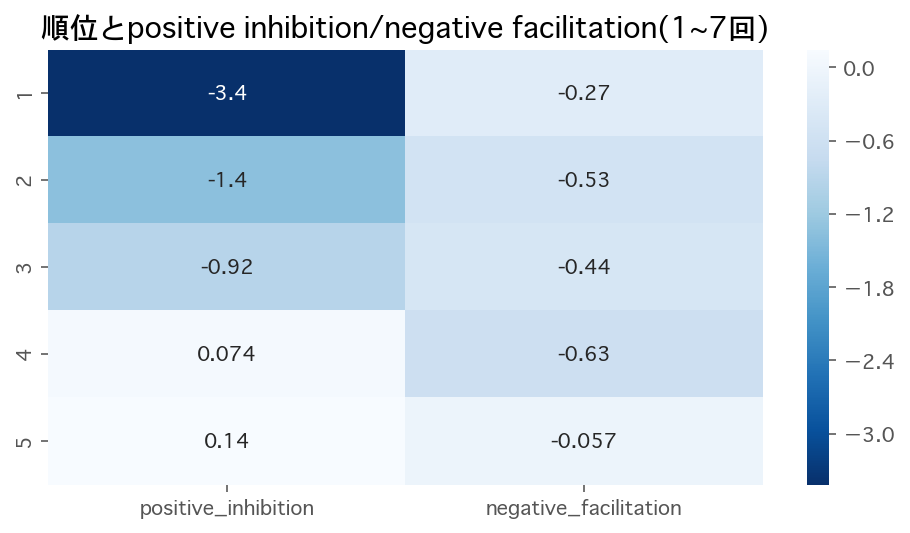

In [29]:
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.heatmap(res_df, cmap='Blues_r', annot=True)
plt.title("順位とpositive inhibition/negative facilitation(1~7回)")

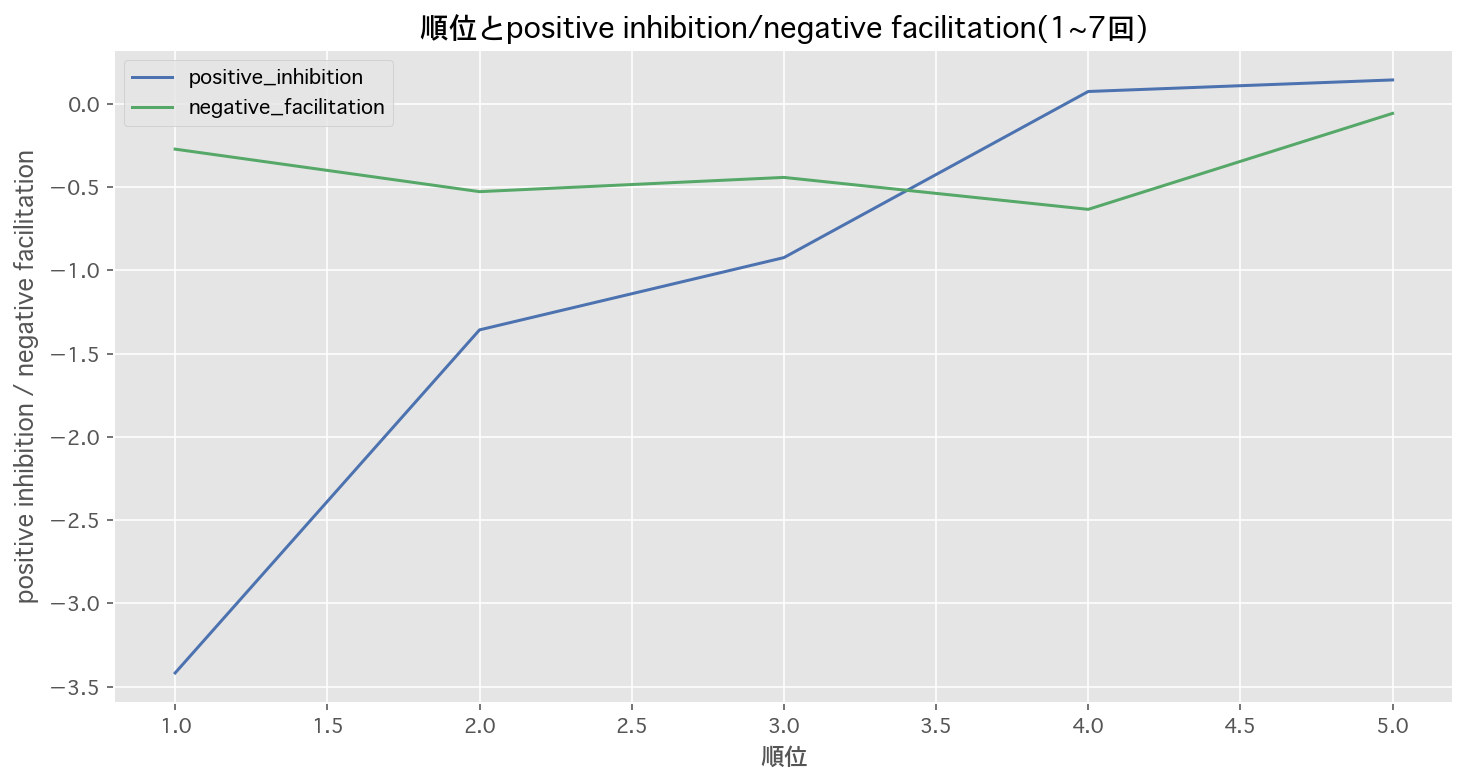

In [30]:
pd.DataFrame([list(order_pos_dict.values()), list(order_neg_dict.values())], index=["positive_inhibition", "negative_facilitation"], columns=[1, 2, 3, 4, 5]).T.plot(figsize=(12, 6))
plt.title("順位とpositive inhibition/negative facilitation(1~7回)")
plt.xlabel("順位")
plt.ylabel("positive inhibition / negative facilitation")

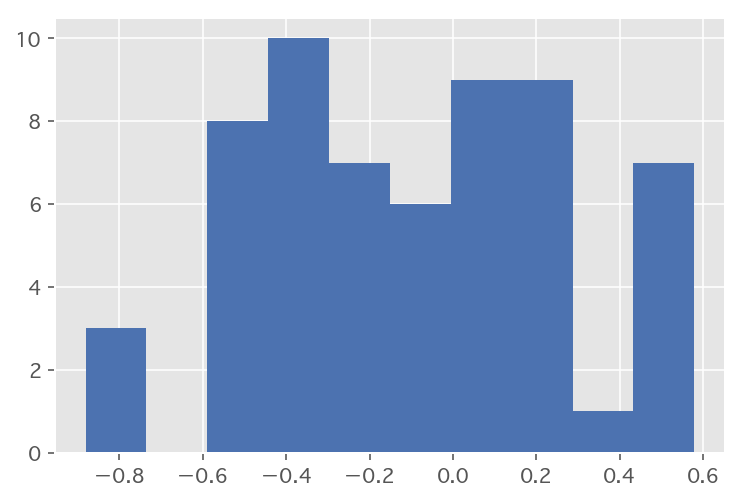

In [16]:
df.loc[:, "positive_inhibition"].hist()

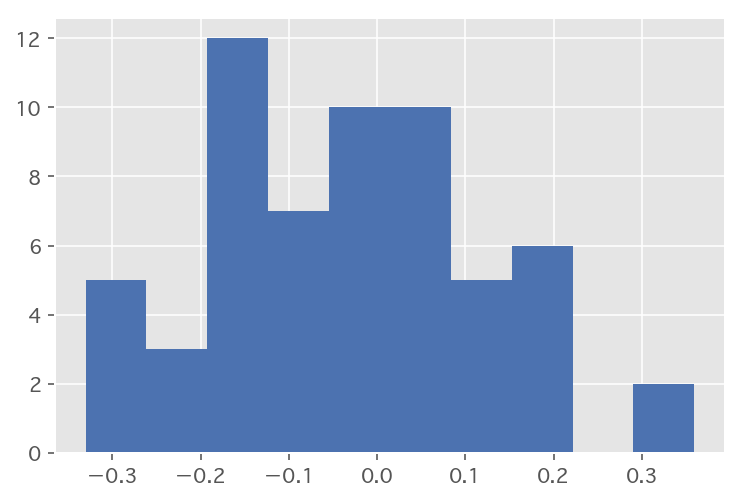

In [17]:
df.loc[:, "negative_facilitation"].hist()